In [1]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
import cmocean

In [2]:
@dataclass
class Extent:
    lats: tuple[float, float]
    lons: tuple[float, float]

    def __post_init__(self):
        if self.lats[0] > self.lats[1]:
            self.up_lat, self.down_lat = self.lats
        else:
            self.down_lat, self.up_lat = self.lats

        if self.lons[0] < self.lons[1]:
            self.left_lon, self.right_lon = self.lons
        else:
            self.right_lon, self.left_lon = self.lons

    def as_xr_slice(self):
        if self.left_lon < 0:
            pos_left_lon = 360 + self.left_lon

        if self.right_lon < 0:
            pos_right_lon = 360 + self.right_lon

        return dict(
            latitude=slice(self.up_lat, self.down_lat),
            longitude=slice(pos_left_lon, pos_right_lon),
        )

    def as_mpl(self):
        return (self.left_lon, self.right_lon, self.down_lat, self.up_lat)


In [3]:
# Read shapefile
municipalities = gpd.read_file("~/Desktop/GIS_drafts/Municipalities/all_municipalities.geojson")
markham = municipalities.loc[municipalities["MUNICIPALITY"].isin(["Markham"])]
chicago = municipalities.loc[municipalities["MUNICIPALITY"].isin(["Chicago"])]
cook_county_border = gpd.read_file("~/Desktop/GIS_drafts/Municipalities/Cook_County_Border.geojson")

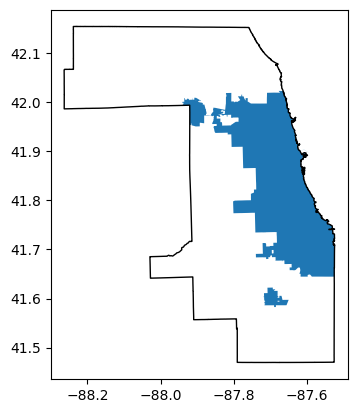

In [4]:
fig, ax = plt.subplots()
ax.set_aspect(True)
markham.plot(ax=ax)
chicago.plot(ax=ax)
cook_county_border.plot(ax=ax, facecolor="None")
plt.show()

In [5]:
# Read a GRIB2 files
files = Path("../data/20210626/").glob("*.grib2")
files = sorted(files)
print(len(files))

717


In [6]:
# Set boundaries
extent = Extent((41.40, 42.2), (-88.30, -87.45))

In [7]:
extent.as_xr_slice()

{'latitude': slice(42.2, 41.4, None), 'longitude': slice(271.7, 272.55, None)}

In [8]:
from typing import Literal
import cartopy.io.img_tiles as cimgt

img = cimgt.OSM(cache=True)

In [11]:
ds = xr.open_dataset(files[350], engine="cfgrib", decode_timedelta=False)

xclip = ds.loc[extent.as_xr_slice()]  # <-- Based on a polygon?
xclip["unknown"].sum()

Ignoring index file '../data/20210626/PrecipRate_00.00_20210626-114200.grib2.5b7b6.idx' incompatible with GRIB file


<xarray.DataArray 'unknown' ()> Size: 4B
array(25196.201, dtype=float32)
Coordinates:
    time            datetime64[ns] 8B ...
    step            float64 8B ...
    heightAboveSea  float64 8B ...
    valid_time      datetime64[ns] 8B ...

In [ ]:
lightcmap = cmocean.tools.lighten(cmocean.cm.rain, 0.9)

def make_figure(file: Path, what_to_do: Literal["return_fig", "save_fig", "show_fig"] = "save_fig"):
    # Bounded to IL and masking NaN pixels
    ds = xr.open_dataset(file, engine="cfgrib", decode_timedelta=False)
    timestr = np.datetime_as_string(ds.time.values.copy(), unit="s")

    xclip = ds.loc[extent.as_xr_slice()]
    masked = xclip.where(xclip["unknown"] != -3)  # No Data
    masked = masked.where(xclip["unknown"] != 0)

    # Define cartopy projections
    # proj = ccrs.Mercator(central_longitude=-87.688, latitude_true_scale=41.6)
    # proj = ccrs.Miller(central_longitude=-87.688)
    # proj = ccrs.Orthographic(central_longitude=-87.688, central_latitude=41.607)

    proj = ccrs.PlateCarree()
    plate = ccrs.PlateCarree()

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Cook County extent
    ax.set_extent(extent.as_mpl(), crs=plate)

    # Add some map features
    ax.add_image(img, 10, zorder=1) # Add OpenStreetMap layer
    # ax.add_feature(cf.LAKES, alpha=0.2, zorder=1)
    # ax.add_feature(cf.STATES, zorder=1)

    masked["unknown"].plot(
        cmap=lightcmap,
        vmin=0,
        vmax=40,
        ax=ax,
        zorder=4,
        transform=plate,
        alpha=0.9,
        cbar_kwargs=dict(label="PrecipRate [mm/hr]", shrink=0.35),
    )

    boundaries_kwargs = dict(transform=plate, zorder=5, facecolor="None", edgecolor="#111")
    markham.plot(ax=ax, **boundaries_kwargs)
    chicago.plot(ax=ax, **boundaries_kwargs)
    cook_county_border.plot(ax=ax, **boundaries_kwargs)

    ax.set_title(timestr, fontsize=10)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

    if what_to_do == "show_fig":
        plt.show()
        plt.close(fig)
        return

    elif what_to_do == "return_fig":
        return fig

    elif what_to_do == "save_fig":
        plt.savefig(f"markham_imgs/{file.name}.png", bbox_inches="tight", dpi=120)
        print(f"Saved {file.name}.png")

        plt.close(fig)
        ds.close()
    return

In [14]:
ds = xr.open_dataset(files[350], engine="cfgrib")
ds

Ignoring index file '../data/20210626/PrecipRate_00.00_20210626-114200.grib2.5b7b6.idx' incompatible with GRIB file
/home/edwin/.virtualenvs/zenv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B ...
    step            timedelta64[ns] 8B ...
    heightAboveSea  float64 8B ...
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B ...
Data variables:
    unknown         (latitude, longitude) float32 98MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-11T13:31 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
xclip = ds.loc[extent.as_xr_slice()]
xclip

<xarray.Dataset> Size: 29kB
Dimensions:         (latitude: 80, longitude: 85)
Coordinates:
    time            datetime64[ns] 8B ...
    step            timedelta64[ns] 8B ...
    heightAboveSea  float64 8B ...
  * latitude        (latitude) float64 640B 42.2 42.19 42.18 ... 41.42 41.41
  * longitude       (longitude) float64 680B 271.7 271.7 271.7 ... 272.5 272.5
    valid_time      datetime64[ns] 8B ...
Data variables:
    unknown         (latitude, longitude) float32 27kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-11T13:31 GRIB to CDM+CF via cfgrib-0.9.1...

Ignoring index file '../data/20210626/PrecipRate_00.00_20210626-114200.grib2.5b7b6.idx' incompatible with GRIB file


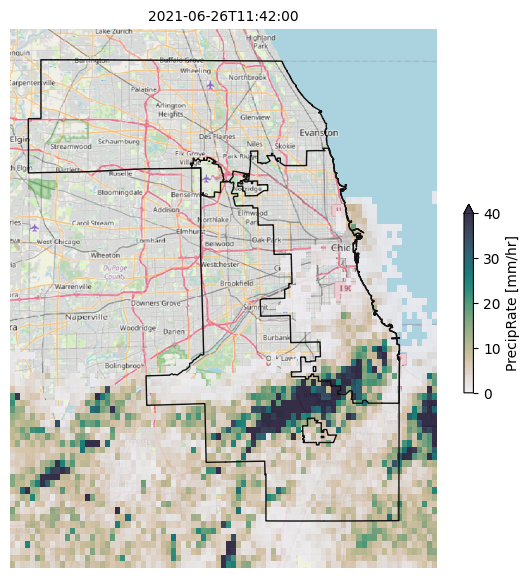

In [12]:
make_figure(files[350], what_to_do="show_fig")